In [3]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from keras.models import Sequential, Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import Callback, EarlyStopping
from keras.utils import to_categorical, load_img, img_to_array
from sklearn.metrics import confusion_matrix
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
os.listdir("dataset1/")

['readme.txt', 'known_images', 'unknown_images']

Load all the images

In [5]:
def load_images():
    images_dir = Path('dataset1/known_images/')
    normal_images = images_dir.glob('normal*.png')
    sick_images = images_dir.glob('sick*.png')
    img_data = []
    label_data = []
    for img in normal_images:
        img_data.append(img)
        label_data.append('normal')
    for img in sick_images:
        img_data.append(img)
        label_data.append('sick')
    df = pd.DataFrame(img_data)
    df.columns = ['images']
    df['labels'] = label_data
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [7]:
df_known_images = load_images()

df_known_images

,images,labels
0,dataset1\known_images\normal_298.png,normal
1,dataset1\known_images\normal_297.png,normal
2,dataset1\known_images\sick_14.png,sick
3,dataset1\known_images\normal_62.png,normal
4,dataset1\known_images\normal_326.png,normal
...,...,...
710,dataset1\known_images\sick_173.png,sick
711,dataset1\known_images\normal_92.png,normal
712,dataset1\known_images\normal_13.png,normal
713,dataset1\known_images\normal_288.png,normal


In [9]:
df_known_images.shape

(715, 2)

We now check if the data is balanced

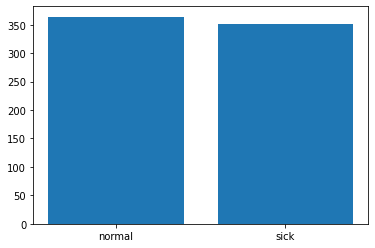

In [10]:
plt.bar(df_known_images['labels'].value_counts().index, df_known_images['labels'].value_counts().values)
plt.show()

Visualise some of the images

In [16]:
def visualise_images(images, labels):
    plt.figure(figsize=(10,5))
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        img = cv2.imread(str(images[i]))
        img = cv2.resize(img, (224, 224))
        plt.imshow(img)
        plt.title(labels[i])
        plt.axis('off')

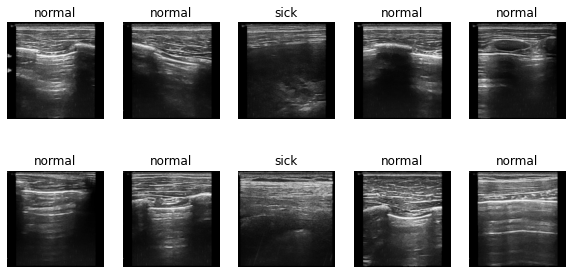

In [17]:
visualise_images(df_known_images['images'], df_known_images['labels'])

Split the data into Test and Training

In [26]:
def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.2, test_split=0.0):
    assert (train_split + test_split + val_split) == 1
    
    # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(train_split * len(df)), int((1 - val_split - test_split) * len(df))]
    
    train_ds, test_ds, val_ds = np.split(df_sample, indices_or_sections)
    
    return train_ds, val_ds, test_ds

In [31]:
train_ds, val_ds, test_ds = get_dataset_partitions_pd(df_known_images)


Check if the training data is balanced

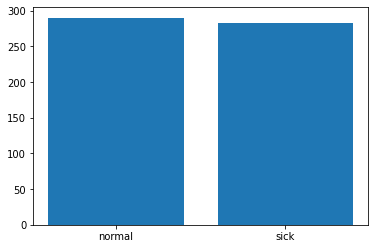

In [34]:
plt.bar(train_ds['labels'].value_counts().index, train_ds['labels'].value_counts().values)
plt.show()

Prepare the Validation Dataset, by processing the images through resizing and changing color scale to RGB

In [50]:
def prepare_dataset(images):
    if 'normal' in images['labels'].values:
        normal_cases = images
    if 'sick' in images['labels'].values:
        sick_cases = images
    data, labels = ([] for x in range(2))
    def prepare(case):
        for img in case['images']:
            img = cv2.imread(str(img))
            img = cv2.resize(img,(224,224))
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32)/255.
            if 'normal' in case['labels'].values:
                label = to_categorical(0 , num_classes=2)
            else:
                label = to_categorical(1 , num_classes=2)
            data.append(img)
            labels.append(label)
        return data, labels
    prepare(normal_cases)
    d,l = prepare(sick_cases)
    d = np.array(d)
    l = np.array(l)
    return d,l



In [56]:
val_data, val_labels = prepare_dataset(val_ds)
print(len(val_data))

286


We’ll now write a function to generate images in batches from the train set.

In [58]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size

    # define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32) 
    batch_labels = np.zeros((batch_size, 2), dtype=np.float32)

    # get a numpy array of all the indices of the input data
    indices = np.arrange(n) 

    #initialize a counter
    
